<a href="https://colab.research.google.com/github/abhikmr778/RFH/blob/main/Nrx6K20_train_DDPG_parameterNoise_Uplink_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""cell_free_ul_reward_state_update_30dBm.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1589qShRSOT9j6evPI_C-XxGqxPkwZL2P
"""



# Commented out IPython magic to ensure Python compatibility.
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import pandas as pd
# import keras.backend.tensorflow_backend as backend
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout, Conv2D, LayerNormalization, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Input,Add, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
#from object_detection.utils.networks import tfSummary, OrnsteinUhlenbeckProcess
!rm -rf ./logs/ 
from collections import deque
import time
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from pathlib import Path
from keras import losses
import h5py
from datetime import datetime  
import argparse
import pprint as pp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'/testlogs')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path2 = Path(base_dir+str(datetime.now().strftime("%c"))+'/models')
dest2 = path2
model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)
path3 = Path(base_dir+'2020-01-30 19:42:04.279775'+'/models')
dest3 = path3
restore_path = base_dir+'Thu Jul 23 01:53:05 2020/models'

Mounted at /content/gdrive


In [3]:
# DISCOUNT = 0.7
REPLAY_MEMORY_SIZE = 20000
# MIN_REPLAY_MEMORY_SIZE = 512
MINIBATCH_SIZE = 32
#UPDATE_TARGET_EVERY = 100
MIN_REWARD = 30

EPISODES = 1000
UPDATES = 50
# EPOCH = 10
# START = 0
EPSILON = 0.6
MIN_EPSILON = 0.01
EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
# var = 10
# min_var = 1e-5
# var_decay = np.power(min_var,(1/(EPISODES)))
# MIN_EPSILON = 0

AGGREGATE_STATS_EVERY = 1
np.random.seed(2)
tf.compat.v1.set_random_seed(2)

In [4]:
# channelGains['channelGain'][0].shape
np.random.rand(10, 32).shape

(10, 32)

In [5]:
class wirelessEnv:
    def __init__(self, pu, nrx, gainspath, random_seed):
        print(pu)
        random.seed(random_seed)
        self.filename = base_dir+str(gainspath)
        self.channelGains = h5py.File(self.filename, 'r')
        self.B = 20000000
        self.N0 = 1

        self.T_c = 0.001
        
        self.Ptcm = 0.2
        self.Ptcl = 0.2
        self.Pom = 0.825
        self.pp = 0.2
        
        self.K = 20
        self.tauc = 200
        self.eff = 0.4 #amplifier efficiency
        self.M = 32
        self.pu = pu
        #self.ui = 4 # for all i
        #self.F = 3
        #self.Pfix =  # for all i
        self.Pft = 10
        self.C_fh = 100000000
        self.nu = 2
        self.a = 0.88115
        self.b = 0.88115
        self.taup = self.K
        self.tauf = 1 - (self.taup/self.tauc)
        #print(self.tauf)
        self.Nrx = nrx
        
        self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
        #print(self.R_fh)
        self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
        #print(self.Pfix)
        self.theta_max = 1
        #self.sigma2 = self.F*self.N0*self.B
        self.alpha = deque(maxlen=2)
        self.beta = deque(maxlen=2)
        self.ch_gain = deque(maxlen=2)
        self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
        self.pi = deque(maxlen=2)
        self.initialize_p()
        self.a_dim = 1 # we decide the cardinality as per the required resolution
        self.action_bound = np.asarray([0, 1])
        # initialize actions
        #self.actions = [0.00001]  
        #for x in range(self.action_space-1):
            #self.actions.append((x+1)*self.theta_max/(self.action_space-1))    
        # input/output for the neural net
        #self.s_dim = 8*self.K + 4*self.M + 2
        self.s_dim = self.K*self.M
        # self.s_dim = 4*self.M + 3*self.K - 1
        self.input = 100
        self.output = self.a_dim
        
    def initialize_matrix(self, episode):
        for t in range(2):
          # BETA = np.random.rand(self.M, self.K)
          BETA = self.channelGains['channelGain'][episode].transpose()
          gamma_num = np.zeros((self.M,self.K))
          gamma_den = np.zeros((self.M,self.K))

          Gamma = np.zeros((self.M,self.K))
          for m in range(self.M):
              for k in range(self.K):
                  gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                  gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                  Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
          self.ch_gain.append(Gamma)
          alpha1 = np.zeros((self.K,))
          for k in range(self.K):
              #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
              alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
          self.alpha.append(alpha1)
          beta1 = np.zeros((self.K,self.K))
          for k in range(self.K):
              for q in range(self.K):
                  beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
          self.beta.append(beta1)
          # if episode >= 1999:
          #   print(f'Gamma:{Gamma}')
          #self.alpha_beta.append(np.array([[np.random.uniform(0,1) for e in range(K)] for e in range(K)]))        
        return

    def initialize_p(self):
        for t in range(2):
          self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
        return
    
    def cal_alpha_p(self, i, t):
        val = self.alpha[t][i]*self.pi[t][i]
        # print(f'cal_alpha_p: {val}')
        return val
    
    def cal_beta_p(self, i, j, t):
        val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
        # print(f'cal_beta_p: {val}')
        return val
    
    def sum_beta_p(self, i, t):
        val = 0
        for j in range(self.K):
            val += self.cal_beta_p(i,j,t)  
        #val = val + (self.b-self.a*self.a)*self.Nrx*self.pu*np.sum(np.square(np.asarray(self.ch_gain)[t,:,i]))/(np.asarray(self.ch_gain)[t,:,i]))
        # print(f'sum_beta_p: {val}')
        return val 

    def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + self.b/(self.a*self.a)*self.sum_beta_p(i, t))))
        return val
        
    def cal_EEi(self,i,t):
        val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
        return val

    def cal_total_WSEE(self,t):
        val = 0
        for x in range(self.K):
            val += self.wi[x]*self.cal_EEi(x,t)
        return val
    
    def cal_equal_p_WSEE(self, t):
        p = [self.theta_max for x in range(self.K)]
        temp = self.pi.copy()
        self.pi[t] = p
        val = self.cal_total_WSEE(t)
        self.pi = temp
        return val
  

    def cal_reward(self,i,t):
        #ri = self.wi[i]*self.cal_EEi(i,t) - self.sum_price(i,t)
        # ri = self.cal_total_WSEE(t)
        # ri = (np.log(self.cal_total_WSEE(t)) - np.log(self.cal_equal_p_WSEE(t)))
        ri = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t) 
        return ri

  
    def cal_state(self,i):
        state = []
        indx = 0
        for t in reversed(range(1)): #for current timestep only
            # next two elements in states are alpha(t)*pi(t-1) and Σbeta(t)pi(t-1)
            #state.append(self.cal_alpha_p(i,t)) # 2
            #state.append(self.sum_beta_p(i,t)) # 2
          for m in range(self.M):
            for k in range(self.K):
              state.append(self.ch_gain[t][m][k]) #M
            # state.append(self.ch_gain[t][m][i]*self.pi[t][i]) #M
            # print(f'ch_gain: {self.ch_gain[t][m][i]}')
            # print(f'pi: {self.pi[t][i]}')
          #2*2*M

          # next elements in states are the interferences from other users to ith user at time step t
          #for x in range(self.K):                               
              #state.append(self.cal_interfering(i,x,t)) # K
              #state.append(self.cal_EEi(x,t)) # K
          # 2xK
          
          # next elements in states are the interfered users by the ith user at time step t
          # for x in range(self.K):
          #     if x!= i:                    
          #         if t==1:
          #           # print(f'cal_alpha_p: {self.cal_alpha_p(x,1)}')
          #           # print(f'cal_beta_p: {self.cal_beta_p(i,x,1)}')
          #           # print(f'sum_beta_p: {self.sum_beta_p(x,1)}')
          #           state.append(self.cal_alpha_p(x,1)) # K-1
          #           # state.append(self.cal_total_WSEE(t)) # K-1
          #           state.append(self.cal_beta_p(i,x,1)) # K-1
          #           state.append(self.sum_beta_p(x,1)) # K-1
                      
                  #state.append(self.cal_interfered(i,x,t)) # K-1
          # 4x(K-1)
        
        # pi(t-1) and WSEEi(t-1)
        # print(f'cal_total_WSEE: {self.cal_total_WSEE(1)}')
        # state.append(self.pi[1][i])
        # state.append(self.cal_total_WSEE(1))        # 1
        #return np.asarray(state)
        state = np.reshape(state, [1, self.s_dim])
        return np.asarray(-np.log10(state))

    def initialize_state(self):
        UE = random.randint(0,self.K-1)
        state = self.cal_state(UE)
        return state, UE

    def reset(self, episode):
        self.initialize_matrix(episode)
#         self.initialize_p()
        self.episode_step = 0
        state, agent_no = self.initialize_state()
        return state, agent_no

    def initialize_state_test(self, UE):
        state = self.cal_state(UE)
        return state

    def reset_test(self, episode):
        self.initialize_matrix(episode)
        self.episode_step = 0

    def agent_reset(self):
        state, agent_no = self.initialize_state()
        state = np.reshape(state, [1, self.s_dim])
        return state, agent_no

            
    def step(self, action, agent):
        self.episode_step += 1
        temp = self.pi[1].copy()
        temp[agent] = action #action generated from action network (+noise+bounding)
        self.pi.append(temp)
        next_state = self.cal_state(agent)
        reward = self.cal_reward(agent,1)
        next_state = np.reshape(next_state, [1, self.s_dim])
        done = False
        if self.episode_step >= UPDATES:
            done = True
        return next_state, reward, done


In [6]:
class ReplayBuffer():
    def __init__(self, random_seed=1337):
        self.buffer = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.priorities = deque(maxlen = REPLAY_MEMORY_SIZE)
        random.seed(random_seed)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities)**priority_scale
        # print(f'shape {scaled_priorities}, sum {np.sum(scaled_priorities)}')
        sampled_probabilities = scaled_priorities/sum(scaled_priorities)
        return sampled_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance/max(importance)
        return importance_normalized

    def sample(self, priority_scale = 0.7):
        samples = random.sample(self.buffer, MINIBATCH_SIZE)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k = MINIBATCH_SIZE, weights= sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return samples, importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [7]:
class AdaptiveParamNoise:
  def __init__(self, initial_stddev=0.05, desired_action_stddev=0.05, adoption_coefficient=1.01):
    self.initial_stddev = tf.Variable(initial_stddev)
    self.desired_action_stddev = tf.Variable(desired_action_stddev)
    self.adoption_coefficient = tf.Variable(adoption_coefficient)
    self.current_stddev = tf.Variable(initial_stddev)

  def adapt_stddev(self, distance):
    return tf.cond(distance > self.desired_action_stddev,
                    lambda: self.current_stddev.assign(tf.compat.v1.div(self.current_stddev, self.adoption_coefficient)),
                    lambda: self.current_stddev.assign(tf.compat.v1.multiply(self.current_stddev, self.adoption_coefficient)))
    
  def __repr__(self):
    _repr = 'AdaptiveParamNoise(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
    return _repr.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)

In [8]:
class Stats:
  def __init__(self, sess, shape=()):
    self.sess = sess
    self.sum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(0.0),
        name='runningsum', trainable=False)
    self.sqsum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(1e-2),
        name='runningsqsum', trainable=False)
    self.count = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=(),
        initializer=tf.constant_initializer(1e-2),
        name='count', trainable=False)
    
    self.mean = tf.compat.v1.div(self.sum, self.count)
    self.std = tf.clip_by_value(
        tf.sqrt(tf.compat.v1.squared_difference(tf.sqrt(tf.compat.v1.div(self.sqsum, self.count)),self.mean)),1e-2, 10)
    
    self.sum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.sqsum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.count_next = tf.compat.v1.placeholder(tf.float32, shape=())
    self.update_op = [self.sum.assign_add(self.sum_next), self.sqsum.assign_add(self.sqsum_next),
                      self.count.assign_add(self.count_next)]

  def update(self, state):
    self.sess.run(self.update_op, feed_dict={self.sum_next: state.sum(axis=0),
                                             self.sqsum_next: np.square(state).sum(axis=0),
                                             self.count_next: np.array(len(state), dtype='float32')})

In [9]:
def normalize(x, stats):
    if stats is None:
        return x
    return (x - stats.mean) / stats.std


In [10]:
class Actor:
    def __init__(self, sess, s_dim, a_dim, normalize_observations=True,
                 use_param_noise=False, tau=0.01, gamma=.99, delta=0.2, learning_rate=0.0001,
                 observation_range=(-5., 5.)):
        #main model #gets trained every step
        
        self.save_path = path2
        self.sess = sess
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.delta = delta
        self.lr = learning_rate
        self.observation_range = observation_range
        self.normalize_observations = normalize_observations

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim], name='states_a')
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32, name='drop_prob_a')
        self.critic_gradients = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim], 'critic_grad_a')
        self.obs_rms = None


        #Observation normalization
        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, self.s_dim)

        with tf.compat.v1.variable_scope('actor'):
          self.actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.policy_params = tf.compat.v1.trainable_variables(scope='actor')


        if use_param_noise: 
          with tf.compat.v1.variable_scope('perturbed_actor'):
            self.perturbed_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
          self.perturbed_policy_params = tf.compat.v1.trainable_variables(scope='perturbed_actor')
        
          self.adapt_noise = AdaptiveParamNoise()
          self.stddev_ph = tf.compat.v1.placeholder(tf.float32)

          self.action_distance, self.stddev = self.adaptive_param_noise()

          self.updated_perturbed_policy_params = [self.perturbed_policy_params[i].assign(self.policy_params[i] + tf.random.normal(tf.shape(self.perturbed_policy_params[i]), 0.,self.stddev_ph, seed=1337)) for i in range(len(self.perturbed_policy_params)) if 'LayerNorm' not in self.perturbed_policy_params[i].name]


        with tf.compat.v1.variable_scope('target_actor'):
          self.target_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.target_policy_params = tf.compat.v1.trainable_variables(scope='target_actor')

        self.objective_gradient = \
            tf.gradients(self.actions, self.policy_params, -self.critic_gradients)

        self.update_policy_params = tf.compat.v1.train.AdamOptimizer(self.lr).apply_gradients(
            zip(self.objective_gradient, self.policy_params))

        # print(f'policy_params{np.array(self.policy_params).shape}, target_policy_params{np.array(self.target_policy_params).shape}')
        # print(f'policy_params{self.policy_params}')
        # print(f'target_policy_params{self.target_policy_params}')
        
        self.update_target_policy_params = [self.target_policy_params[i].assign(
                                                                  self.tau * self.policy_params[i]
                                                                  + (1 - self.tau) *
                                                                  self.target_policy_params[i]
                                                                  )
                                                        for i in range(len(self.target_policy_params))]

        # self.merge_op = tf.summary.merge_all(scope='Actor')
        self.saver = tf.compat.v1.train.Saver()




    def policy_network(self, state, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])

        # input = Input(shape = (self.s_dim,))
        h1 = Dense(128)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('relu')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)

        # h1 = tf.layers.dense(state, 128)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)

        h2 = Dense(64)(h1)
        h2 = LayerNormalization(center=True , scale=True)(h2)
        h2 = Activation('tanh')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.layers.dense(h1, 128)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        h3 = Dense(32)(h2)
        h3 = LayerNormalization(center=True , scale=True)(h3)
        h3 = Activation('relu')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        h4 = Dense(16)(h3)
        h4 = LayerNormalization(center=True , scale=True)(h4)
        h4 = Activation('tanh')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        h5 = Dense(8)(h4)
        h5 = LayerNormalization(center=True , scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h4 = tf.layers.dense(h3, 64)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        actions = Dense(self.a_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))(h5)
        actions = Activation('relu')(actions)

        # actions = tf.layers.dense(h4, self.action_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))
        # actions = tf.nn.tanh(actions)

        return actions

    def add_param_noise(self, state):
        adaptive_policy_distance, stddev = self.sess.run([self.action_distance, self.stddev],
                                                         feed_dict={self.state_ph: state, self.drop_prob_ph: 0.0})
        self.sess.run(self.updated_perturbed_policy_params, feed_dict={self.stddev_ph: stddev})

        return adaptive_policy_distance, stddev

    def adaptive_param_noise(self):
        adaptive_policy_distance = tf.sqrt(tf.reduce_mean(
            tf.compat.v1.squared_difference(self.actions, self.perturbed_actions)))
        
        std_dev = self.adapt_noise.adapt_stddev(adaptive_policy_distance)

        return adaptive_policy_distance, std_dev

    def train(self, state, drop_prob, critic_grads):
        self.sess.run(self.update_policy_params, feed_dict={self.state_ph: state,
                                                            self.drop_prob_ph: drop_prob,
                                                            self.critic_gradients: critic_grads})
        
    def predict(self, state, drop_prob):
        return self.sess.run(self.actions, feed_dict={self.state_ph: state,
                                                      self.drop_prob_ph: drop_prob})

    def perturbed_predict(self, state, drop_prob):
        return self.sess.run(self.perturbed_actions, feed_dict={self.state_ph: state,
                                                                self.drop_prob_ph: drop_prob})
        
    def target_predict(self, state, drop_prob):
        return self.sess.run(self.target_actions, feed_dict={self.state_ph: state,
                                                             self.drop_prob_ph: drop_prob})
        
    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')   

        

In [11]:
class Critic:
    def __init__(self, sess, s_dim ,a_dim, normalize_observations=True,
                 tau=0.01, gamma=.99, learning_rate=0.001, l2_reg=0.01, observation_range=(-5., 5.)):
        
        self.sess = sess
        self.save_path = path2
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.lr = learning_rate
        self.l2_reg = l2_reg
        self.gamma = gamma
        self.normalize_observations = normalize_observations
        self.observation_range = observation_range
        self.obs_rms = None

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim])
        self.action_ph = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim])
        self.future_reward_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.importance_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32)

        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, shape=self.s_dim)

        with tf.compat.v1.variable_scope('critic'):
          self.q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.q_params = tf.compat.v1.trainable_variables(scope='critic')

        with tf.compat.v1.variable_scope('target_critic'):
          self.target_q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.target_q_params = tf.compat.v1.trainable_variables(scope='target_critic')

        self.critic_gradients = tf.gradients(self.q_value, self.action_ph)

        self.loss = tf.reduce_mean((self.importance_ph**(1-EPSILON))*tf.compat.v1.squared_difference(self.q_value, self.future_reward_ph)) + \
                    self.l2_reg*tf.compat.v1.losses.get_regularization_loss(scope='critic')

        # self.loss = tf.compat.v1.losses.mean_squared_error(self.predict(self.state_ph, self.action_ph, self.drop_prob_ph), self.future_reward_ph, weights = self.importance_ph**(1-EPSILON), scope='critic')

        # mse = tf.keras.losses.MeanSquaredError()
        # self.loss = mse(self.future_reward_ph, self.q_value, sample_weight = self.importance_ph**(1-EPSILON))

        self.update_q_params = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.update_target_q_params = [self.target_q_params[i].assign(self.tau*self.q_params[i]+(1-self.tau)*self.target_q_params[i]) for i in range(len(self.target_q_params))]

        self.saver = tf.compat.v1.train.Saver()

        # self.merge_op = tf.summary.merge_all(scope='critic')

    def q_value_network(self, state, action, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])



        # Layer 1
        h1 = Dense(128, kernel_regularizer=tf.nn.l2_loss)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('tanh')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)
        # h1 = tf.layers.dense(state, 128, kernel_regularizer=tf.nn.l2_loss)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)
        

        # Layer 2 + add actions
        h2 = tf.keras.layers.concatenate([h1, action], axis=-1)

        h2 = Dense(64, kernel_regularizer=tf.nn.l2_loss)(h2)
        h2 = LayerNormalization(center=True, scale=True)(h2)
        h2 = Activation('relu')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.concat([h1, action], axis=-1)

        # h2 = tf.layers.dense(h2, 128, kernel_regularizer=tf.nn.l2_loss)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        # Layer 3
        h3 = Dense(32, kernel_regularizer=tf.nn.l2_loss)(h2)
        h3 = LayerNormalization(center=True, scale=True)(h3)
        h3 = Activation('tanh')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64, kernel_regularizer=tf.nn.l2_loss)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        # Layer 4
        h4 = Dense(16, kernel_regularizer=tf.nn.l2_loss)(h3)
        h4 = LayerNormalization(center=True, scale=True)(h4)
        h4 = Activation('relu')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        # h4 = tf.layers.dense(h3, 64, kernel_regularizer=tf.nn.l2_loss)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        # Layer 5
        h5 = Dense(8, kernel_regularizer=tf.nn.l2_loss)(h4)
        h5 = LayerNormalization(center=True, scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h5 = tf.layers.dense(h4, 64, kernel_regularizer=tf.nn.l2_loss)
        # h5 = tc.layers.layer_norm(h5, center=True, scale=True)
        # h5 = tf.nn.elu(h5)
        # h5 = tf.layers.dropout(h5, drop_prob, seed=seed)

        # Output q_value
        q_value = Dense(1, kernel_regularizer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))(h5)
        # q_value = tf.layers.dense(h4, 1, kernel_initializer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))

        return q_value

    def compute_grads(self, state, action, drop_prob):
        return self.sess.run(self.critic_gradients, feed_dict={self.state_ph: state,
                                                               self.action_ph: action,
                                                               self.drop_prob_ph: drop_prob})

    def train(self, state, action, drop_prob, future_reward, importance):
        return self.sess.run([self.loss, self.update_q_params], feed_dict={self.state_ph: state,
                                                         self.action_ph: action,
                                                         self.drop_prob_ph: drop_prob,
                                                         self.future_reward_ph: future_reward,
                                                         self.importance_ph: importance})

    def predict(self, state, action, drop_prob):
        return self.sess.run(self.q_value, feed_dict={self.state_ph: state,
                                                      self.action_ph: action,
                                                      self.drop_prob_ph: drop_prob})

    def target_predict(self, state, action, drop_prob):
        return self.sess.run(self.target_q_value, feed_dict={self.state_ph: state,
                                                             self.action_ph: action,
                                                             self.drop_prob_ph: drop_prob})

    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')




In [12]:
def variable_summaries(var, name):
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Namespace(actor_lr=0.001, buffer_size=10000, critic_lr=0.01, delta=0.2, drop_prob=0.4, gamma=0.99, l2_reg=0.0, max_episode_len=20000, max_episodes=1000, max_exploration_steps=1000000.0, minibatch_size=512, normalize_obs=True, random_seed=1337, restore=False, save=True, summary_dir='./results/tf_ddpg', tau=0.01, train=True, train_step=50, use_adaptive_parameter_noise=True)
1.0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/1000 [00:00<?, ?episode/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<12:58,  1.28episode/s]

Loss: None|| Global step: 50 || Episode: 1 || Reward: -1.36 || Distance: nan ||
wsee: 0.16563211226301588, eqwsee: 0.20852538201892834, reward: -1.3592873799567262
|| Test Run No: 1100 || WSEE: 0.2415438645480817 || eq_WSEE: 0.19534912110252511 || Reward: 0.80 ||
|| Test Run No: 1120 || WSEE: 0.1391508241399425 || eq_WSEE: 0.1660994950491523 || Reward: -0.07 ||
|| Test Run No: 1140 || WSEE: 0.19427816815492796 || eq_WSEE: 0.18663268911887868 || Reward: -0.20 ||
|| Test Run No: 1160 || WSEE: 0.1872445297639064 || eq_WSEE: 0.17446902060410943 || Reward: -1.09 ||
|| Test Run No: 1180 || WSEE: 0.2070293725948292 || eq_WSEE: 0.20838432201940266 || Reward: 0.14 ||
wsee:0.17011387150879081, fpa_wsee: 0.1823838112312948


  0%|          | 2/1000 [00:13<1:14:36,  4.49s/episode]

Loss: None|| Global step: 100 || Episode: 2 || Reward: -1.69 || Distance: nan ||
wsee: 0.18419364259706583, eqwsee: 0.16854937371337234, reward: -1.6900392229790264


  0%|          | 3/1000 [00:14<55:07,  3.32s/episode]  

Loss: None|| Global step: 150 || Episode: 3 || Reward: -0.68 || Distance: nan ||
wsee: 0.16319260289293688, eqwsee: 0.1784195262452741, reward: -0.6806083760530813
|| Test Run No: 1100 || WSEE: 0.2420943797152154 || eq_WSEE: 0.19534912110252511 || Reward: 0.87 ||
|| Test Run No: 1120 || WSEE: 0.1391508241399425 || eq_WSEE: 0.1660994950491523 || Reward: -0.07 ||
|| Test Run No: 1140 || WSEE: 0.19427816815492796 || eq_WSEE: 0.18663268911887868 || Reward: -0.20 ||
|| Test Run No: 1160 || WSEE: 0.1872445297639064 || eq_WSEE: 0.17446902060410943 || Reward: -1.09 ||
|| Test Run No: 1180 || WSEE: 0.2070293725948292 || eq_WSEE: 0.20838432201940266 || Reward: 0.14 ||
wsee:0.17011937666046215, fpa_wsee: 0.1823838112312948


  0%|          | 4/1000 [00:27<1:41:18,  6.10s/episode]

Loss: None|| Global step: 200 || Episode: 4 || Reward: 0.61 || Distance: nan ||
wsee: 0.18419364259706583, eqwsee: 0.16854937371337234, reward: 0.6135508420520965


  0%|          | 5/1000 [00:27<1:13:48,  4.45s/episode]

Loss: None|| Global step: 250 || Episode: 5 || Reward: -2.21 || Distance: nan ||
wsee: 0.1476340581261941, eqwsee: 0.19410391727391804, reward: -2.2058581919771125
|| Test Run No: 1100 || WSEE: 0.24142773764169884 || eq_WSEE: 0.19534912110252511 || Reward: 0.77 ||
|| Test Run No: 1120 || WSEE: 0.1391508241399425 || eq_WSEE: 0.1660994950491523 || Reward: -0.07 ||
|| Test Run No: 1140 || WSEE: 0.19427816815492796 || eq_WSEE: 0.18663268911887868 || Reward: -0.20 ||
|| Test Run No: 1160 || WSEE: 0.1872445297639064 || eq_WSEE: 0.17446902060410943 || Reward: -1.09 ||
|| Test Run No: 1180 || WSEE: 0.2070293725948292 || eq_WSEE: 0.20838432201940266 || Reward: 0.14 ||
wsee:0.170112710239727, fpa_wsee: 0.1823838112312948


  1%|          | 6/1000 [00:40<1:54:32,  6.91s/episode]

Loss: None|| Global step: 300 || Episode: 6 || Reward: 1.54 || Distance: nan ||
wsee: 0.18419364259706583, eqwsee: 0.16854937371337234, reward: 1.541491763543246


  1%|          | 7/1000 [00:40<1:23:05,  5.02s/episode]

Loss: None|| Global step: 350 || Episode: 7 || Reward: 1.45 || Distance: nan ||
wsee: 0.1861597966134874, eqwsee: 0.16503933344451563, reward: 1.4452428245968132
|| Test Run No: 1100 || WSEE: 0.24066109149248674 || eq_WSEE: 0.19534912110252511 || Reward: 0.67 ||
|| Test Run No: 1120 || WSEE: 0.1391508241399425 || eq_WSEE: 0.1660994950491523 || Reward: -0.07 ||
|| Test Run No: 1140 || WSEE: 0.19427816815492796 || eq_WSEE: 0.18663268911887868 || Reward: -0.20 ||
|| Test Run No: 1160 || WSEE: 0.1872445297639064 || eq_WSEE: 0.17446902060410943 || Reward: -1.09 ||
|| Test Run No: 1180 || WSEE: 0.2070293725948292 || eq_WSEE: 0.20838432201940266 || Reward: 0.14 ||
wsee:0.17010504377823488, fpa_wsee: 0.1823838112312948


  1%|          | 8/1000 [00:53<2:01:20,  7.34s/episode]

Loss: None|| Global step: 400 || Episode: 8 || Reward: -2.84 || Distance: nan ||
wsee: 0.18419364259706583, eqwsee: 0.16854937371337234, reward: -2.8433101804468532


  1%|          | 9/1000 [00:54<1:27:50,  5.32s/episode]

Loss: None|| Global step: 450 || Episode: 9 || Reward: 0.13 || Distance: nan ||
wsee: 0.1720814315597732, eqwsee: 0.16912996858853324, reward: 0.1286050618199356
|| Test Run No: 1100 || WSEE: 0.24012090429237257 || eq_WSEE: 0.19534912110252511 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.1391508241399425 || eq_WSEE: 0.1660994950491523 || Reward: -0.07 ||
|| Test Run No: 1140 || WSEE: 0.19427816815492796 || eq_WSEE: 0.18663268911887868 || Reward: -0.20 ||
|| Test Run No: 1160 || WSEE: 0.1872445297639064 || eq_WSEE: 0.17446902060410943 || Reward: -1.09 ||
|| Test Run No: 1180 || WSEE: 0.2070293725948292 || eq_WSEE: 0.20838432201940266 || Reward: 0.14 ||
wsee:0.17009964190623372, fpa_wsee: 0.1823838112312948


  1%|1         | 10/1000 [01:07<2:05:03,  7.58s/episode]

Loss: None|| Global step: 500 || Episode: 10 || Reward: 1.42 || Distance: nan ||
wsee: 0.18419364259706583, eqwsee: 0.16854937371337234, reward: 1.4156891083324745


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

Loss: 0.027080224826931953|| Global step: 550 || Episode: 11 || Reward: 1.01 || Distance: 0.0730 ||
wsee: 0.1530441595483833, eqwsee: 0.1402988895818462, reward: 1.0138940773631906
|| Test Run No: 1100 || WSEE: 0.2499947891979456 || eq_WSEE: 0.19534912110252511 || Reward: -0.66 ||
|| Test Run No: 1120 || WSEE: 0.20181886106248145 || eq_WSEE: 0.1660994950491523 || Reward: 0.76 ||
|| Test Run No: 1140 || WSEE: 0.23930124703855604 || eq_WSEE: 0.18663268911887868 || Reward: 1.04 ||
|| Test Run No: 1160 || WSEE: 0.2260589953249432 || eq_WSEE: 0.17446902060410943 || Reward: 0.99 ||
|| Test Run No: 1180 || WSEE: 0.259137788890454 || eq_WSEE: 0.20838432201940266 || Reward: 1.10 ||
wsee:0.22979825343806298, fpa_wsee: 0.1823838112312948


  1%|1         | 12/1000 [01:25<2:23:23,  8.71s/episode]

Loss: 0.005622725002467632|| Global step: 600 || Episode: 12 || Reward: -5.24 || Distance: 0.0506 ||
wsee: 0.21838383780595222, eqwsee: 0.16854937371337234, reward: -5.235346585856133


  1%|1         | 13/1000 [01:26<1:49:49,  6.68s/episode]

Loss: 0.014978202059864998|| Global step: 650 || Episode: 13 || Reward: -4.12 || Distance: 0.0447 ||
wsee: 0.03165874110485041, eqwsee: 0.15979249447083305, reward: -4.119932344007986
|| Test Run No: 1100 || WSEE: 0.26146371297073445 || eq_WSEE: 0.19534912110252511 || Reward: 1.05 ||
|| Test Run No: 1120 || WSEE: 0.2128989965356004 || eq_WSEE: 0.1660994950491523 || Reward: 0.93 ||
|| Test Run No: 1140 || WSEE: 0.24334495689715951 || eq_WSEE: 0.18663268911887868 || Reward: 1.13 ||
|| Test Run No: 1160 || WSEE: 0.2285608762121012 || eq_WSEE: 0.17446902060410943 || Reward: 1.06 ||
|| Test Run No: 1180 || WSEE: 0.2683912303327754 || eq_WSEE: 0.20838432201940266 || Reward: 1.24 ||
wsee:0.2339181878332438, fpa_wsee: 0.1823838112312948
Model could have been saved!


  1%|1         | 14/1000 [01:40<2:24:59,  8.82s/episode]

Loss: 0.01366915088146925|| Global step: 700 || Episode: 14 || Reward: 0.09 || Distance: 0.1089 ||
wsee: 0.22244093843630494, eqwsee: 0.16854937371337234, reward: 0.08540251511398833


  2%|1         | 15/1000 [01:42<1:51:13,  6.78s/episode]

Loss: 0.0029584995936602354|| Global step: 750 || Episode: 15 || Reward: 2.33 || Distance: 0.0982 ||
wsee: 0.2280750656462779, eqwsee: 0.1744942778006663, reward: 2.3302337517356793
|| Test Run No: 1100 || WSEE: 0.2507530008051194 || eq_WSEE: 0.19534912110252511 || Reward: -0.60 ||
|| Test Run No: 1120 || WSEE: 0.20954786860234045 || eq_WSEE: 0.1660994950491523 || Reward: 0.88 ||
|| Test Run No: 1140 || WSEE: 0.24203166669362208 || eq_WSEE: 0.18663268911887868 || Reward: 1.10 ||
|| Test Run No: 1160 || WSEE: 0.22749850697724003 || eq_WSEE: 0.17446902060410943 || Reward: 1.02 ||
|| Test Run No: 1180 || WSEE: 0.2679316632403896 || eq_WSEE: 0.20838432201940266 || Reward: 1.23 ||
wsee:0.23242937288472304, fpa_wsee: 0.1823838112312948


  2%|1         | 16/1000 [01:56<2:26:20,  8.92s/episode]

Loss: 0.00848241988569498|| Global step: 800 || Episode: 16 || Reward: -5.26 || Distance: 0.0445 ||
wsee: 0.22197469750924712, eqwsee: 0.16854937371337234, reward: -5.255288393091814


  2%|1         | 17/1000 [01:58<1:51:59,  6.84s/episode]

Loss: 0.011451714672148228|| Global step: 850 || Episode: 17 || Reward: 2.34 || Distance: 0.0940 ||
wsee: 0.20652751183019738, eqwsee: 0.15903164212737855, reward: 2.341671130225628
|| Test Run No: 1100 || WSEE: 0.251362086269851 || eq_WSEE: 0.19534912110252511 || Reward: 0.79 ||
|| Test Run No: 1120 || WSEE: 0.20658075862000536 || eq_WSEE: 0.1660994950491523 || Reward: 0.83 ||
|| Test Run No: 1140 || WSEE: 0.24099111910144927 || eq_WSEE: 0.18663268911887868 || Reward: 1.08 ||
|| Test Run No: 1160 || WSEE: 0.226812417826775 || eq_WSEE: 0.17446902060410943 || Reward: 1.00 ||
|| Test Run No: 1180 || WSEE: 0.2679704486529 || eq_WSEE: 0.20838432201940266 || Reward: 1.22 ||
wsee:0.2314902398102935, fpa_wsee: 0.1823838112312948
Model could have been saved!


  2%|1         | 18/1000 [02:12<2:26:54,  8.98s/episode]

Loss: 0.008700313977897167|| Global step: 900 || Episode: 18 || Reward: 3.23 || Distance: 0.0970 ||
wsee: 0.22168931184020818, eqwsee: 0.16854937371337234, reward: 3.226604381377493


  2%|1         | 19/1000 [02:14<1:52:43,  6.89s/episode]

Loss: 0.029834385961294174|| Global step: 950 || Episode: 19 || Reward: 2.30 || Distance: 0.0550 ||
wsee: 0.24155989873153683, eqwsee: 0.17792399210252283, reward: 2.296193015948459
|| Test Run No: 1100 || WSEE: 0.25593108332098496 || eq_WSEE: 0.19534912110252511 || Reward: 1.04 ||
|| Test Run No: 1120 || WSEE: 0.20613832905385618 || eq_WSEE: 0.1660994950491523 || Reward: 0.83 ||
|| Test Run No: 1140 || WSEE: 0.24050962635540654 || eq_WSEE: 0.18663268911887868 || Reward: 1.07 ||
|| Test Run No: 1160 || WSEE: 0.2265341416191874 || eq_WSEE: 0.17446902060410943 || Reward: 1.00 ||
|| Test Run No: 1180 || WSEE: 0.2683377430425796 || eq_WSEE: 0.20838432201940266 || Reward: 1.22 ||
wsee:0.2311941319758487, fpa_wsee: 0.1823838112312948
Model could have been saved!


  2%|2         | 20/1000 [02:28<2:27:31,  9.03s/episode]

Loss: 0.013513553887605667|| Global step: 1000 || Episode: 20 || Reward: 3.35 || Distance: 0.1528 ||
wsee: 0.22167252220755743, eqwsee: 0.16854937371337234, reward: 3.353449839005302


  2%|2         | 21/1000 [02:30<1:53:23,  6.95s/episode]

Loss: 0.010672795586287975|| Global step: 1050 || Episode: 21 || Reward: -4.27 || Distance: 0.0379 ||
wsee: 0.018550236720875104, eqwsee: 0.18498033365736571, reward: -4.267401776180175
|| Test Run No: 1100 || WSEE: 0.25026341232689886 || eq_WSEE: 0.19534912110252511 || Reward: -0.68 ||
|| Test Run No: 1120 || WSEE: 0.20749255120253374 || eq_WSEE: 0.1660994950491523 || Reward: 0.85 ||
|| Test Run No: 1140 || WSEE: 0.24068022600090444 || eq_WSEE: 0.18663268911887868 || Reward: 1.07 ||
|| Test Run No: 1160 || WSEE: 0.22660233055068935 || eq_WSEE: 0.17446902060410943 || Reward: 1.00 ||
|| Test Run No: 1180 || WSEE: 0.2689173307672682 || eq_WSEE: 0.20838432201940266 || Reward: 1.23 ||
wsee:0.23136115936250715, fpa_wsee: 0.1823838112312948


  2%|2         | 22/1000 [02:44<2:28:06,  9.09s/episode]

Loss: 0.016698939725756645|| Global step: 1100 || Episode: 22 || Reward: -9.17 || Distance: 0.0975 ||
wsee: 0.22186688808125804, eqwsee: 0.16854937371337234, reward: -9.17225347154936


  2%|2         | 23/1000 [02:46<1:53:51,  6.99s/episode]

Loss: 0.006625549867749214|| Global step: 1150 || Episode: 23 || Reward: 2.63 || Distance: 0.0632 ||
wsee: 0.245169208052052, eqwsee: 0.18806454048385768, reward: 2.633593746953912
|| Test Run No: 1100 || WSEE: 0.2519047686093587 || eq_WSEE: 0.19534912110252511 || Reward: 0.80 ||
|| Test Run No: 1120 || WSEE: 0.21235492671080514 || eq_WSEE: 0.1660994950491523 || Reward: 0.93 ||
|| Test Run No: 1140 || WSEE: 0.24191238416849847 || eq_WSEE: 0.18663268911887868 || Reward: 1.10 ||
|| Test Run No: 1160 || WSEE: 0.22748096275124904 || eq_WSEE: 0.17446902060410943 || Reward: 1.02 ||
|| Test Run No: 1180 || WSEE: 0.26967248714136005 || eq_WSEE: 0.20838432201940266 || Reward: 1.24 ||
wsee:0.23257081976856625, fpa_wsee: 0.1823838112312948
Model could have been saved!


  2%|2         | 24/1000 [03:01<2:28:53,  9.15s/episode]

Loss: 0.021752653643488884|| Global step: 1200 || Episode: 24 || Reward: 2.06 || Distance: 0.0901 ||
wsee: 0.22235831763908817, eqwsee: 0.16854937371337234, reward: 2.061961022298421


  2%|2         | 25/1000 [03:03<1:54:41,  7.06s/episode]

Loss: 0.018618110567331314|| Global step: 1250 || Episode: 25 || Reward: 1.86 || Distance: 0.0937 ||
wsee: 0.19291042850097992, eqwsee: 0.15199726746565612, reward: 1.8595781044567326
|| Test Run No: 1100 || WSEE: 0.2646138567116315 || eq_WSEE: 0.19534912110252511 || Reward: 1.39 ||
|| Test Run No: 1120 || WSEE: 0.21566555344815777 || eq_WSEE: 0.1660994950491523 || Reward: 0.99 ||
|| Test Run No: 1140 || WSEE: 0.24321615046522205 || eq_WSEE: 0.18663268911887868 || Reward: 1.12 ||
|| Test Run No: 1160 || WSEE: 0.22844200183502716 || eq_WSEE: 0.17446902060410943 || Reward: 1.04 ||
|| Test Run No: 1180 || WSEE: 0.270679963710864 || eq_WSEE: 0.20838432201940266 || Reward: 1.26 ||
wsee:0.23392588796338643, fpa_wsee: 0.1823838112312948
Model could have been saved!


  3%|2         | 26/1000 [03:17<2:29:25,  9.20s/episode]

Loss: 0.017832383513450623|| Global step: 1300 || Episode: 26 || Reward: 2.75 || Distance: 0.0960 ||
wsee: 0.2231163631138256, eqwsee: 0.16854937371337234, reward: 2.7535735695968393


  3%|2         | 27/1000 [03:19<1:55:10,  7.10s/episode]

Loss: 0.0175178162753582|| Global step: 1350 || Episode: 27 || Reward: 2.90 || Distance: 0.0284 ||
wsee: 0.2375143744594251, eqwsee: 0.17860475363457406, reward: 2.901821111394144
|| Test Run No: 1100 || WSEE: 0.2591132266485331 || eq_WSEE: 0.19534912110252511 || Reward: 1.15 ||
|| Test Run No: 1120 || WSEE: 0.216508050915786 || eq_WSEE: 0.1660994950491523 || Reward: 1.00 ||
|| Test Run No: 1140 || WSEE: 0.2435900695253425 || eq_WSEE: 0.18663268911887868 || Reward: 1.13 ||
|| Test Run No: 1160 || WSEE: 0.22870391719616587 || eq_WSEE: 0.17446902060410943 || Reward: 1.05 ||
|| Test Run No: 1180 || WSEE: 0.27160176351174903 || eq_WSEE: 0.20838432201940266 || Reward: 1.28 ||
wsee:0.23426699607195303, fpa_wsee: 0.1823838112312948
Model could have been saved!


  3%|2         | 28/1000 [03:33<2:29:01,  9.20s/episode]

Loss: 0.014279398135840893|| Global step: 1400 || Episode: 28 || Reward: 2.26 || Distance: 0.1203 ||
wsee: 0.22375699151495523, eqwsee: 0.16854937371337234, reward: 2.25772547095278


  3%|2         | 29/1000 [03:36<1:54:47,  7.09s/episode]

Loss: 0.006051544100046158|| Global step: 1450 || Episode: 29 || Reward: -4.05 || Distance: 0.1240 ||
wsee: 0.018675808657995233, eqwsee: 0.19509641247160098, reward: -4.050604093596593
|| Test Run No: 1100 || WSEE: 0.25730208394053783 || eq_WSEE: 0.19534912110252511 || Reward: 1.05 ||
|| Test Run No: 1120 || WSEE: 0.2164937719981508 || eq_WSEE: 0.1660994950491523 || Reward: 1.00 ||
|| Test Run No: 1140 || WSEE: 0.24352004803559904 || eq_WSEE: 0.18663268911887868 || Reward: 1.13 ||
|| Test Run No: 1160 || WSEE: 0.22872877094001715 || eq_WSEE: 0.17446902060410943 || Reward: 1.05 ||
|| Test Run No: 1180 || WSEE: 0.2722725815131994 || eq_WSEE: 0.20838432201940266 || Reward: 1.28 ||
wsee:0.23423642361958977, fpa_wsee: 0.1823838112312948
Model could have been saved!


  3%|3         | 30/1000 [03:50<2:31:09,  9.35s/episode]

Loss: 0.01266855001449585|| Global step: 1500 || Episode: 30 || Reward: 0.72 || Distance: 0.0632 ||
wsee: 0.22415803582846852, eqwsee: 0.16854937371337234, reward: 0.7199314736056699


  3%|3         | 31/1000 [03:52<1:56:59,  7.24s/episode]

Loss: 0.008055479265749454|| Global step: 1550 || Episode: 31 || Reward: 3.69 || Distance: 0.0905 ||
wsee: 0.2667860289434741, eqwsee: 0.19508742811983226, reward: 3.689996275918657
|| Test Run No: 1100 || WSEE: 0.2627617125221336 || eq_WSEE: 0.19534912110252511 || Reward: 1.27 ||
|| Test Run No: 1120 || WSEE: 0.21841622895128465 || eq_WSEE: 0.1660994950491523 || Reward: 1.04 ||
|| Test Run No: 1140 || WSEE: 0.24409569866679437 || eq_WSEE: 0.18663268911887868 || Reward: 1.14 ||
|| Test Run No: 1160 || WSEE: 0.22914686815261615 || eq_WSEE: 0.17446902060410943 || Reward: 1.06 ||
|| Test Run No: 1180 || WSEE: 0.27297323818927466 || eq_WSEE: 0.20838432201940266 || Reward: 1.30 ||
wsee:0.23490815734132894, fpa_wsee: 0.1823838112312948
Model could have been saved!


  3%|3         | 32/1000 [04:07<2:30:55,  9.35s/episode]

Loss: 0.008940325118601322|| Global step: 1600 || Episode: 32 || Reward: 3.16 || Distance: 0.0443 ||
wsee: 0.2246126907888586, eqwsee: 0.16854937371337234, reward: 3.1550970522073785


  3%|3         | 33/1000 [04:09<1:56:04,  7.20s/episode]

Loss: 0.00904524140059948|| Global step: 1650 || Episode: 33 || Reward: -3.20 || Distance: 0.0230 ||
wsee: 0.0343616529696423, eqwsee: 0.15758441079644953, reward: -3.195629345911468
|| Test Run No: 1100 || WSEE: 0.26048205245034795 || eq_WSEE: 0.19534912110252511 || Reward: 1.18 ||
|| Test Run No: 1120 || WSEE: 0.22037501785172575 || eq_WSEE: 0.1660994950491523 || Reward: 1.07 ||
|| Test Run No: 1140 || WSEE: 0.24554112216478793 || eq_WSEE: 0.18663268911887868 || Reward: 1.17 ||
|| Test Run No: 1160 || WSEE: 0.23021855716174694 || eq_WSEE: 0.17446902060410943 || Reward: 1.09 ||
|| Test Run No: 1180 || WSEE: 0.27362751348512876 || eq_WSEE: 0.20838432201940266 || Reward: 1.31 ||
wsee:0.2372539457997972, fpa_wsee: 0.1823838112312948
Model could have been saved!


  3%|3         | 34/1000 [04:23<2:29:00,  9.25s/episode]

Loss: 0.014485368505120277|| Global step: 1700 || Episode: 34 || Reward: 0.19 || Distance: 0.1713 ||
wsee: 0.22517246752163814, eqwsee: 0.16854937371337234, reward: 0.19261351522820114


  4%|3         | 35/1000 [04:25<1:54:55,  7.15s/episode]

Loss: 0.008788884617388248|| Global step: 1750 || Episode: 35 || Reward: 2.50 || Distance: 0.0737 ||
wsee: 0.2020564777454843, eqwsee: 0.15216566421525388, reward: 2.4979702802791928
|| Test Run No: 1100 || WSEE: 0.25868694579460916 || eq_WSEE: 0.19534912110252511 || Reward: -0.50 ||
|| Test Run No: 1120 || WSEE: 0.22187346605171573 || eq_WSEE: 0.1660994950491523 || Reward: 1.10 ||
|| Test Run No: 1140 || WSEE: 0.24680051346833812 || eq_WSEE: 0.18663268911887868 || Reward: 1.20 ||
|| Test Run No: 1160 || WSEE: 0.23116195716903196 || eq_WSEE: 0.17446902060410943 || Reward: 1.11 ||
|| Test Run No: 1180 || WSEE: 0.2746744510437754 || eq_WSEE: 0.20838432201940266 || Reward: 1.33 ||
wsee:0.23894985088867726, fpa_wsee: 0.1823838112312948
Model could have been saved!


  4%|3         | 36/1000 [04:39<2:28:53,  9.27s/episode]

Loss: 0.01064290851354599|| Global step: 1800 || Episode: 36 || Reward: -4.03 || Distance: 0.0712 ||
wsee: 0.22586490541773685, eqwsee: 0.16854937371337234, reward: -4.026934453672866


  4%|3         | 37/1000 [04:42<1:55:05,  7.17s/episode]

Loss: 0.016835063695907593|| Global step: 1850 || Episode: 37 || Reward: -5.76 || Distance: 0.0499 ||
wsee: 0.0006234463422176188, eqwsee: 0.1784585540992793, reward: -5.760773076937195
|| Test Run No: 1100 || WSEE: 0.26180346331567583 || eq_WSEE: 0.19534912110252511 || Reward: 1.14 ||
|| Test Run No: 1120 || WSEE: 0.2227576300368214 || eq_WSEE: 0.1660994950491523 || Reward: 1.12 ||
|| Test Run No: 1140 || WSEE: 0.24756074295062103 || eq_WSEE: 0.18663268911887868 || Reward: 1.22 ||
|| Test Run No: 1160 || WSEE: 0.23181708347889582 || eq_WSEE: 0.17446902060410943 || Reward: 1.12 ||
|| Test Run No: 1180 || WSEE: 0.27560620166212585 || eq_WSEE: 0.20838432201940266 || Reward: 1.35 ||
wsee:0.23977380775390883, fpa_wsee: 0.1823838112312948
Model could have been saved!


  4%|3         | 38/1000 [04:56<2:28:16,  9.25s/episode]

Loss: 0.013542886823415756|| Global step: 1900 || Episode: 38 || Reward: 0.07 || Distance: 0.0978 ||
wsee: 0.22644494007124064, eqwsee: 0.16854937371337234, reward: 0.07214293386524606


  4%|3         | 39/1000 [04:58<1:54:34,  7.15s/episode]

Loss: 0.014311475679278374|| Global step: 1950 || Episode: 39 || Reward: 3.23 || Distance: 0.0837 ||
wsee: 0.24187226445803486, eqwsee: 0.17770538706690966, reward: 3.2319852623500025
|| Test Run No: 1100 || WSEE: 0.26603882243639937 || eq_WSEE: 0.19534912110252511 || Reward: 1.40 ||
|| Test Run No: 1120 || WSEE: 0.22376737691207865 || eq_WSEE: 0.1660994950491523 || Reward: 1.14 ||
|| Test Run No: 1140 || WSEE: 0.24850450608756647 || eq_WSEE: 0.18663268911887868 || Reward: 1.24 ||
|| Test Run No: 1160 || WSEE: 0.2324559851672584 || eq_WSEE: 0.17446902060410943 || Reward: 1.14 ||
|| Test Run No: 1180 || WSEE: 0.27622386491575845 || eq_WSEE: 0.20838432201940266 || Reward: 1.37 ||
wsee:0.24066513747831483, fpa_wsee: 0.1823838112312948
Model could have been saved!


  4%|4         | 40/1000 [05:12<2:28:35,  9.29s/episode]

Loss: 0.010368268936872482|| Global step: 2000 || Episode: 40 || Reward: 3.13 || Distance: 0.0499 ||
wsee: 0.2269816281690012, eqwsee: 0.16854937371337234, reward: 3.134966079018784


  4%|4         | 41/1000 [05:15<1:55:04,  7.20s/episode]

Loss: 0.007633796893060207|| Global step: 2050 || Episode: 41 || Reward: 3.03 || Distance: 0.1126 ||
wsee: 0.30187856341737457, eqwsee: 0.23911901182021947, reward: 3.0303840158560873
|| Test Run No: 1100 || WSEE: 0.2660314572779524 || eq_WSEE: 0.19534912110252511 || Reward: 1.42 ||
|| Test Run No: 1120 || WSEE: 0.22447473709823174 || eq_WSEE: 0.1660994950491523 || Reward: 1.15 ||
|| Test Run No: 1140 || WSEE: 0.24924583044206183 || eq_WSEE: 0.18663268911887868 || Reward: 1.25 ||
|| Test Run No: 1160 || WSEE: 0.23311810212970882 || eq_WSEE: 0.17446902060410943 || Reward: 1.15 ||
|| Test Run No: 1180 || WSEE: 0.2767367957211081 || eq_WSEE: 0.20838432201940266 || Reward: 1.38 ||
wsee:0.2413652321145096, fpa_wsee: 0.1823838112312948
Model could have been saved!


  4%|4         | 42/1000 [05:29<2:30:16,  9.41s/episode]

Loss: 0.009009035304188728|| Global step: 2100 || Episode: 42 || Reward: 3.30 || Distance: 0.0712 ||
wsee: 0.22737631284820156, eqwsee: 0.16854937371337234, reward: 3.3049819599013905


  4%|4         | 43/1000 [05:32<1:56:22,  7.30s/episode]

Loss: 0.012230177409946918|| Global step: 2150 || Episode: 43 || Reward: 2.75 || Distance: 0.0867 ||
wsee: 0.22011857771268964, eqwsee: 0.1658882943111362, reward: 2.7462439049586815
|| Test Run No: 1100 || WSEE: 0.2598969321468973 || eq_WSEE: 0.19534912110252511 || Reward: 1.04 ||
|| Test Run No: 1120 || WSEE: 0.22518241814001136 || eq_WSEE: 0.1660994950491523 || Reward: 1.16 ||
|| Test Run No: 1140 || WSEE: 0.2500004698240651 || eq_WSEE: 0.18663268911887868 || Reward: 1.27 ||
|| Test Run No: 1160 || WSEE: 0.23382187078851963 || eq_WSEE: 0.17446902060410943 || Reward: 1.17 ||
|| Test Run No: 1180 || WSEE: 0.2774683407479819 || eq_WSEE: 0.20838432201940266 || Reward: 1.39 ||
|| Test Run No: 1200 || WSEE: 0.24455946381686372 || eq_WSEE: 0.18311652878272475 || Reward: 1.22 ||
|| Test Run No: 1220 || WSEE: 0.24963276530315595 || eq_WSEE: 0.17756881833051075 || Reward: 1.40 ||
|| Test Run No: 1240 || WSEE: 0.2499030211875136 || eq_WSEE: 0.1849714369194631 || Reward: 1.31 ||
|| Test Run No:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:369: RuntimeWarning: invalid value encountered in double_scalars


wsee:0.19011445367618068, test_wsee: nan, agent.env.pi: [0.03609831 0.03609831 0.03609831 0.03609831 0.03609831 0.03609831
 0.03609831 0.03609831 0.03609831 0.03609831 0.03609831 0.03609831
 0.03609831 0.03609831 0.03609831 0.03609831 0.03609831 0.03609831
 0.03609831 0.03609831]


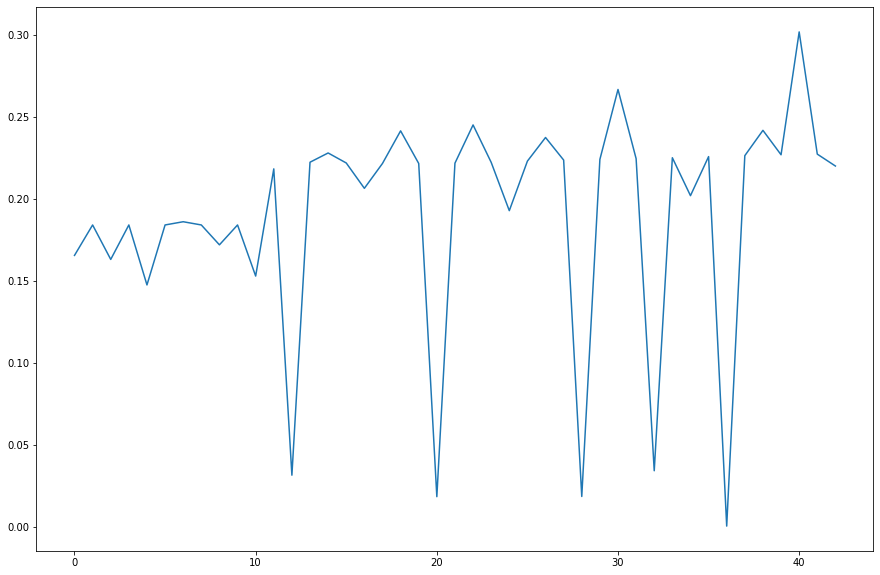

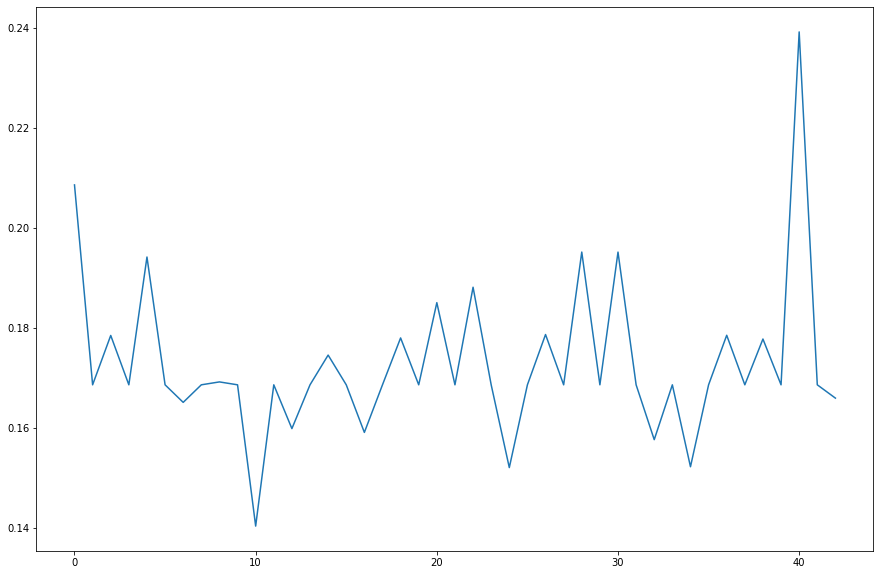

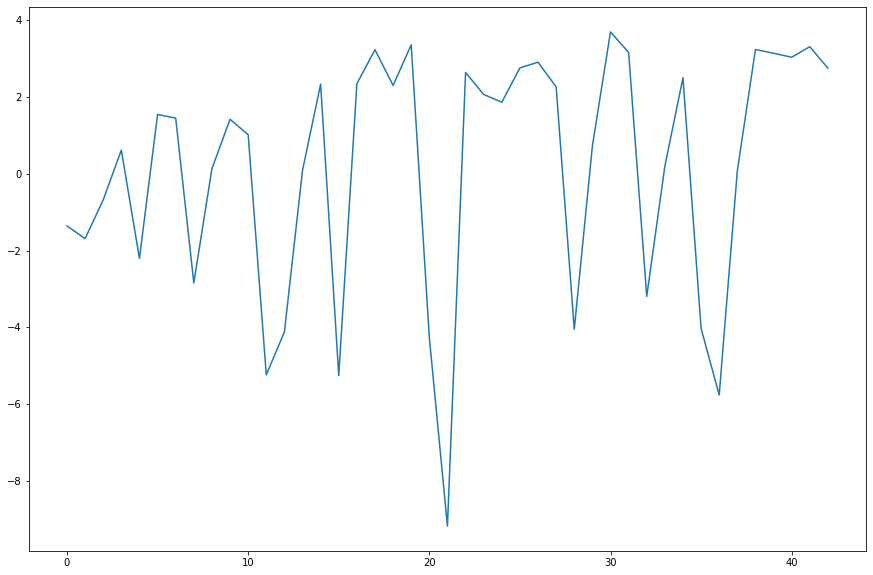

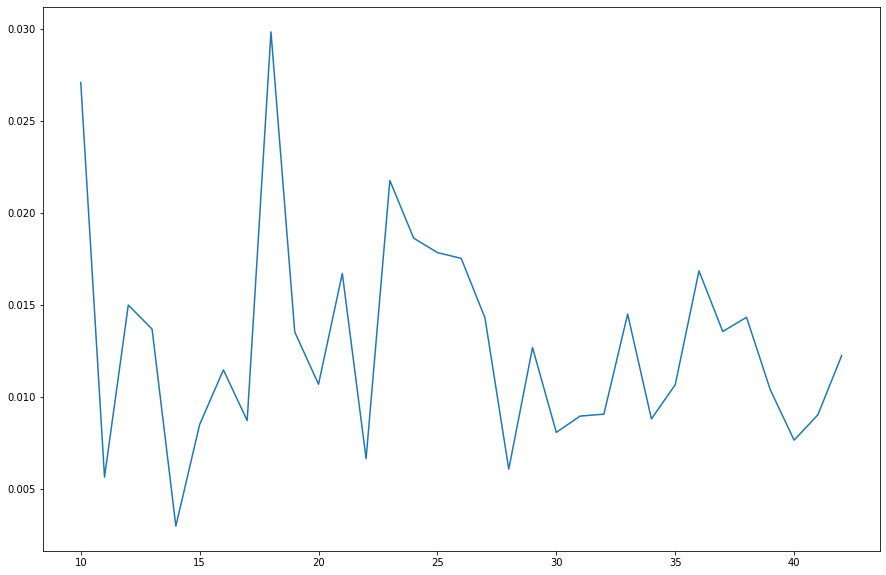

In [13]:
def preprocess_state(state):
    return np.expand_dims(state, 0)

def build_summaries():
    with tf.compat.v1.variable_scope('total_reward'):
      var = tf.Variable(0.)
      tf.summary.scalar('reward', var)
      tf.summary.histogram('histogram', var)
    return tf.summary.merge_all(scope='total_reward'), var


def restore_model(sess,saver):
    saver.restore(sess, str(restore_path)+'/model_vars.ckpt')


def save_model(sess,saver,wsee,fpa):
    saver.save(sess, str(path2)+'/model_vars_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

def train(sess, env, params, actor, critic, noise, state_dim, action_dim,action_min,action_max, saver):
    global ep_rewards, ep_wsee, equal_wsee, test_ep_rewards, test_ep_wsee, df_wsee, df_eqwsee, df_loss, df_reward, result, EPSILON, MIN_EPSILON, EPSILON_DECAY
    EPSILON = 0.6
    MIN_EPSILON = 0.0001
    EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
    result = [None, None]
    ep_rewards = [] 
    ep_wsee = []
    equal_wsee =[]
    test_ep_rewards = []
    test_ep_wsee = []
    df_wsee = pd.DataFrame(columns=['wsee'])
    df_eqwsee = pd.DataFrame(columns=['eqwsee'])
    df_reward = pd.DataFrame(columns=['reward'])
    df_loss = pd.DataFrame(columns=['loss'])
    sess.run(tf.compat.v1.initialize_all_variables())

    sess.run([actor.update_target_policy_params, critic.update_target_q_params])

    replay_buffer = ReplayBuffer(random_seed=int(params['random_seed']))

    total_steps = 0
    total_episodes = 0

    if params['restore']:
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')
        total_steps, total_episodes = sess.run([total_steps_var, total_episodes_var])

    if params['use_adaptive_parameter_noise']:
      agent = actor.perturbed_predict
    else:
      agent = actor.predict

    max_exploration_steps = params['max_exploration_steps']
    p = 1
    drop_prob = params['drop_prob']
    indicator = False
    counter = 0
    prev_wsee = 0
    for episode in tqdm(range(params['max_episodes']),ascii=True, unit="episode"):


      
      _distance = []
      _std_dev = []
      
      episode_reward = 0

      observation, agent_no = env.reset(episode)

      state = preprocess_state(observation)

      total_reward = 0
      _evaluate = False

      for step in range(params['max_episode_len']):

        if total_steps < max_exploration_steps:

          
          state = np.reshape(state, [1, state_dim])
          # print(f'############################################ step: {step}, state: {state} ###############################################')
          actions = agent(state, drop_prob = drop_prob)
          if not params['use_adaptive_parameter_noise']:
            actions += noise(0, 0.2, action_dim)
            p -= 1/max_exploration_steps
          
        
        else:
          print('### Training Complete ###')
          raise KeyboardInterrupt

        # action = action[0]
        action =  np.clip(actions, action_min, action_max)/action_max
        # print(f'############################################ step: {step, action_max}, action: {action} ###############################################')
        next_state, reward, terminal = env.step(action, agent_no)

        episode_reward += reward


        replay_buffer.add(
            (state, action, reward, terminal, next_state)
        )
        
        # if actor.normalize_observations:
        #   actor.obs_rms.update(state)

        current_state, agent_no = env.agent_reset()
        state = preprocess_state(current_state)
        total_reward += reward
        total_steps += 1

        if total_steps % 100 == 0:
          _evaluate = True

        if terminal:
          if _evaluate:
            test_no = 100
            if episode > 990 or counter == 10:
              test_no = 800
            curr_wsee, indicator = evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee)
            prev_wsee = curr_wsee
            if indicator:
              counter += 1
            else:
              counter = 0
          break

      if counter == 11:
        break
      for train_step in range(params['train_step']):
        if len(replay_buffer.buffer) >= params['minibatch_size']:
          
          minibatch, importance, indices = replay_buffer.sample()
          
          current_states = np.array([np.asarray(transition)[0] for transition in minibatch])
          current_states = np.reshape(current_states, [len(minibatch), state_dim])
          
          current_actions = np.array([np.asarray(transition)[1] for transition in minibatch])
          current_actions = np.reshape(current_actions, [len(minibatch), action_dim])
          # current_actions = np.clip(current_actions, action_min, action_max)/action_max

          current_qs_list = critic.predict(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)
          # current_qs_list = critic.predict(current_states, np.asarray(env.pu*current_actions), drop_prob)
          
          new_states = np.array([np.asarray(transition)[4] for transition in minibatch])
          new_states = np.reshape(new_states, [len(minibatch), state_dim])

          future_actions = actor.target_predict(new_states, drop_prob)
          future_actions = np.clip(future_actions, action_min, action_max)/action_max

          future_qs_list = critic.target_predict(new_states, np.asarray(-np.log10(env.pu*future_actions)), drop_prob)
          # future_qs_list = critic.target_predict(new_states, np.asarray(env.pu*future_actions), drop_prob)
          
          y = []
          errors = []
          for index, (current_state, action, reward, terminal, next_state) in enumerate(minibatch):
              if not terminal:
                future_q = future_qs_list[index]
                new_q = reward + critic.gamma*future_q
                new_action = future_actions[index]
              else:
                new_q = reward
                new_action = action
              current_q = current_qs_list[index]
              errors.append(new_q-current_q)
              y.append(new_q)
          
          y = np.reshape(y, [1, len(minibatch)])
          importance = np.reshape(importance, [1, len(minibatch)])
          result = critic.train(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob, y, importance)
          
          actor.train(current_states, drop_prob,
                      critic.compute_grads(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)[0])
          
          sess.run(actor.update_target_policy_params)
          sess.run(critic.update_target_q_params)

          # errors = y - critic.predict(state_batch,
          #                             actor.predict(state_batch, drop_prob),
          #                             drop_prob)

          if params['use_adaptive_parameter_noise'] and train_step % 20 == 0:
              distance, std_dev = actor.add_param_noise(current_states)
              _distance.append(distance)
              _std_dev.append(std_dev)

          replay_buffer.set_priorities(indices, errors)
      total_episodes += 1
      # distance, std_dev = actor.add_param_noise(current_states)
      # _distance.append(distance)
      # _std_dev.append(std_dev)

      sess.run([total_steps_var.assign(total_steps), total_episodes_var.assign(episode)])
      loss = result[0]
      ep_rewards.append(episode_reward)
      equal_wsee.append(env.cal_equal_p_WSEE(0))
      ep_wsee.append(env.cal_total_WSEE(0))

      if params['use_adaptive_parameter_noise']:
            print(
                f'Loss: {loss}|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} || Distance: {np.array(_distance).mean():.4f} ||')
      else:
          print(
              f'|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} ||')
          

      if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_wsee = sum(ep_wsee[-AGGREGATE_STATS_EVERY:])/len(ep_wsee[-AGGREGATE_STATS_EVERY:])
        average_equal_wsee = sum(equal_wsee[-AGGREGATE_STATS_EVERY:])/len(equal_wsee[-AGGREGATE_STATS_EVERY:])
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(avg_equal_p_wsee = average_equal_wsee, reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, avg_wsee = average_wsee) 
        # cma_reward = (cma_reward + (average_reward-cma_reward)/(episode+1))
        # print(cma_reward)
        df_wsee = df_wsee.append({'wsee': average_wsee}, ignore_index=True)
        df_eqwsee = df_eqwsee.append({'eqwsee': average_equal_wsee}, ignore_index=True)
        df_reward = df_reward.append({'reward': average_reward}, ignore_index=True)
        df_loss = df_loss.append({'loss': loss}, ignore_index=True)
        print(f'wsee: {average_wsee}, eqwsee: {average_equal_wsee}, reward: {average_reward}')
        # agent.tensorboard.update_stats2(rval, train, episode, "loss")
        # agent.tensorboard.update_stats2(average_wsee, train, episode, "wsee")
        # agent.tensorboard.update_stats2(average_equal_wsee, train, episode, "eq_wsee")
        # agent.tensorboard.update_stats2(average_reward, train, episode, "reward")
        # Save model, but only when min reward is greater or equal a set value
        # if min_reward >= MIN_REWARD and episode%5==0:
        # #     #agent.model.save(f'./models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')
        #   actor.actions.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_actor_2.h5')
        #   critic.q_value.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_critic_2.h5')
        if EPSILON > MIN_EPSILON:
          EPSILON *= EPSILON_DECAY
          EPSILON = max(MIN_EPSILON, EPSILON)
      

global eval_wsee, eval_fpa, eval_reward

eval_reward = []
eval_wsee = []
eval_fpa = []

def evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee):

    if params['restore'] and not params['train']:
        sess.run(tf.compat.v1.global_variables_initializer())
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')

    total_steps = sess.run(total_steps_var)

    _reward = []
    _test_wsee = []
    _test_fpa_wsee = []
    flag = 0
    err = 0.01
    start = 1100
    end = start+test_no
    for episode in range(start,end):
        env.reset_test(episode)
        total_reward = 0
        
        for a in range(env.K):
            agent_no = a
            observation = env.initialize_state_test(a)
            state = preprocess_state(observation)
            state = np.reshape(state, [1, state_dim])
            actions = actor.predict(state, drop_prob=0.)
            actions = np.clip(actions, action_min, action_max)/action_max
            action = actions[0]

            _, reward, _ = env.step(action, a)
            
            total_reward += reward
        if total_reward >= 0:
          flag += 1
        _reward.append(total_reward)
        _test_wsee.append(env.cal_total_WSEE(0))
        _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
        if episode % 20 ==0:
          print(f'|| Test Run No: {episode} || WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || Reward: {total_reward:.2f} ||')
    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    eval_wsee.append(wsee)
    eval_fpa.append(fpa)
    eval_reward.append(np.sum(_reward)/len(_reward))
    print(f'wsee:{wsee}, fpa_wsee: {fpa}')
    if flag > 0.95*test_no:
        # save_model(sess,saver,wsee, fpa)
        # actor.save_model(wsee, fpa)
        # critic.save_model(wsee, fpa)
        print('Model could have been saved!')
    # total_reward = np.max(np.array(_reward))
    # summary = sess.run(merge_op, feed_dict={total_reward_var: total_reward})
    # writer.add_summary(summary, total_steps)
        if abs(prev_wsee - wsee) < err: 
          return wsee, True
        else:
          return wsee, False
    else:
      return wsee, False


def main(args, power, nrx):
    params = vars(args)
    tf.compat.v1.set_random_seed(int(params['random_seed']))
    np.random.seed(int(params['random_seed']))
    if params['train']:
      gainspath = 'testNrx/channel_K20_AP32_2k_fresh.h5'
    if params['restore']:
      gainspath = '25thJulyTestGains/channel_K10_AP32_2k.h5'

    with tf.compat.v1.Session() as sess:
        try:
            env = wirelessEnv(power, nrx, gainspath, int(params['random_seed'])) 
            # env = gym.make(args['env'])
            state_dim = env.s_dim
            action_dim = env.a_dim
            action_min = 0.000001
            action_max = power

            # assert (env.action_space.high == -env.action_space.low).all()
            # action_bound = env.action_space.high[0]

            global total_steps_var, total_episodes_var
            total_episodes_var = tf.Variable(0)
            total_steps_var = tf.Variable(0)

            # if args['use_gym_monitor']:
            #     if not args['render_env']:
            #         env = wrappers.Monitor(
            #             env, args['monitor_dir'], video_callable=False, force=True)
            #     else:
            #         env = wrappers.Monitor(env, args['monitor_dir'], force=True)

            actor = Actor(sess, state_dim, action_dim, 
                          use_param_noise=params['use_adaptive_parameter_noise'], 
                          tau=params['tau'], gamma=params['gamma'], 
                          delta=params['delta'], normalize_observations=params['normalize_obs'])
            
            critic = Critic(sess, state_dim, action_dim, tau=params['tau'], gamma=params['gamma'],
                            learning_rate=params['critic_lr'], 
                            normalize_observations=params['normalize_obs'])

            ## Noise
            noise = np.random.normal

            saver = tf.compat.v1.train.Saver()
            # writer = tf.summary.FileWriter(args['summary_dir'] + '/' + args['env'] + '/' + str(datetime.now()))

            if params['train']:
                train(sess,env,params,actor,critic,noise,state_dim,action_dim,action_min,action_max, saver)
            # evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver)
            # save_model(sess,saver)
            # actor.save_model()
            # critic.save_model()
            # print('Model saved!')

        except KeyboardInterrupt:
            if params['save']:
              # save_model(sess,saver)
              # actor.save_model()
              # critic.save_model()
              print('Model saved!')


    test_wsee = np.sum(test_ep_wsee)/len(test_ep_wsee)
    wsee = np.sum(ep_wsee)/len(ep_wsee)
    print(f'wsee:{wsee}, test_wsee: {test_wsee}, agent.env.pi: {env.pi[1]}')

    plt.figure(figsize=(15,10))
    # df_wsee.reset_index().plot(kind='line',x='index', y='wsee')
    plt.plot(df_wsee['wsee'])
    # plt.show()
    plt.savefig(dest/r'wsee.jpg', dpi=300)
    # df_eqwsee.reset_index().plot(kind='line',x='index', y='eqwsee')
    plt.figure(figsize=(15,10))
    plt.plot(df_eqwsee['eqwsee'])
    # nrxmean = df_eqwsee['eqwsee'].mean(axis=0)
    # print(nrxmean, nrx)
    # nrx_val.append(nrxmean*env.B)
    # plt.show()
    plt.savefig(dest/r'eqwsee.jpg', dpi=300)
    # df_reward.reset_index().plot(kind='line',x='index', y='reward')
    plt.figure(figsize=(15,10))
    plt.plot(df_reward['reward'])
    # plt.show()
    plt.savefig(dest/r'reward.jpg', dpi=300)
    # df_loss.reset_index().plot(kind='line',x='index', y='loss')
    plt.figure(figsize=(15,10))
    plt.plot(df_loss['loss'])
    # plt.show()
    plt.savefig(dest/r'loss.jpg', dpi=300)

    df_wsee.to_csv(dest/r'wsee29thJan.csv')
    df_eqwsee.to_csv(dest/r'eqwsee29thJan.csv')
    df_reward.to_csv(dest/r'reward29thJan.csv')
    df_loss.to_csv(dest/r'loss29thJan.csv')


def test(args, power, nrx):
    # tf.set_random_seed(int(args['random_seed']))
    # np.random.seed(int(args['random_seed']))
    params = vars(args)
    gainspath2 = '25thJulyTestGains/channel_K10_AP32_2k.h5'
    with tf.compat.v1.Session() as sess:
    
        env = wirelessEnv(power, nrx, gainspath2) 
        # env = gym.make(args['env'])
        # env.seed(int(args['random_seed']))
        state_dim = env.s_dim
        action_dim = env.a_dim
        action_min = 0.000001
        action_max = power

        global total_steps_var, total_episodes_var
        total_episodes_var = tf.Variable(0)
        total_steps_var = tf.Variable(0)

        saver_actor = tf.compat.v1.train.import_meta_graph(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor/model_actor.ckpt.meta')
        saver_actor.restore(sess, tf.train.latest_checkpoint(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor'))
        sess.run(tf.compat.v1.global_variables_initializer())
        graph = tf.compat.v1.get_default_graph()
        state_ph = graph.get_tensor_by_name("state_ph:0")
        drop_prob = graph.get_tensor_by_name("drop_prob:0")
        predict_operation = graph.get_tensor_by_name("actions:0")
        
        total_steps = sess.run(total_steps_var)
        _reward = []
        _test_wsee = []
        _test_fpa_wsee = []

        for episode in range(2000):
            env.reset_test(episode)
            total_reward = 0
            
            for a in range(env.K):
                agent_no = a
                observation = env.initialize_state_test(a)
                state = preprocess_state(observation)
                state = np.reshape(state, [1, state_dim])
                actions = sess.run(predict_operation, feed_dict = {state_ph: state, drop_prob: 0.0})
                actions = np.clip(actions, action_min, action_max)/action_max
                action = actions[0]

                _, reward, _ = env.step(action, a)
                
                total_reward += reward

            _reward.append(total_reward)
            _test_wsee.append(env.cal_total_WSEE(0))
            _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
            print(f'|| WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || agent.env.pi: {env.pi[1]} || Reward: {total_reward:.2f} ||')



    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    print(f'wsee:{wsee}, fpa_wsee: {test_wsee}')



parser = argparse.ArgumentParser(description='provide arguments for DDPG agent')

# agent parameters
parser.add_argument('--actor-lr', help='actor network learning rate', default=0.001)
parser.add_argument('--critic-lr', help='critic network learning rate', default=0.01)
parser.add_argument('--gamma', help='discount factor for critic updates', default=0.99)
parser.add_argument('--tau', help='soft target update parameter', default=0.01)
parser.add_argument('--use-adaptive-parameter-noise', help='', default=True)
parser.add_argument('--delta', help='desired action deviation', default=.2)
parser.add_argument('--l2_reg', help='Q loss regularization strength', default=.0)
parser.add_argument('--drop-prob', help='drop out probability', default=.4)
parser.add_argument('--buffer-size', help='max size of the replay buffer', default=10000)
parser.add_argument('--minibatch-size', help='size of minibatch for minibatch-SGD', default=512)
parser.add_argument('--normalize-obs', help='normalizes observations', default=True)

# run parameters
parser.add_argument('--train', help='train the model', default=True)
parser.add_argument('--train_step', help='number of training steps', default=50)
parser.add_argument('--max-exploration-steps', help='', default=1e6)
# parser.add_argument('--env', help='choose the gym env', default='HalfCheetah-v2')
parser.add_argument('--save', help='save trained model', default=True)
parser.add_argument('--restore', help='restore prev trained model', default=False)
parser.add_argument('--random-seed', help='random seed for repeatability', default=1337)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1000)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=20000)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
# parser.add_argument('--use-gym-monitor', help='record gym results', action='store_true')
# parser.add_argument('--monitor-dir', help='directory for storing gym results', default='./results/gym_ddpg')
parser.add_argument('--summary-dir', help='directory for storing tensorboard info', default='./results/tf_ddpg')

parser.set_defaults()
# parser.set_defaults(use_gym_monitor=False)

args, _ = parser.parse_known_args()

# with open('./random_seeds_used', 'a+') as f:
#     f.write(f"Time: {str(datetime.now())}, random seed: {args['random_seed']}\n")


pp.pprint(args)
# merge_op, total_reward_var = build_summaries()
power = 30
nrx = 6
main(args, np.power(10,power/10 - 3), nrx)


In [14]:
episode = [int(i*100) for i in range(1,len(eval_wsee)+1)]
# episode = episode*500

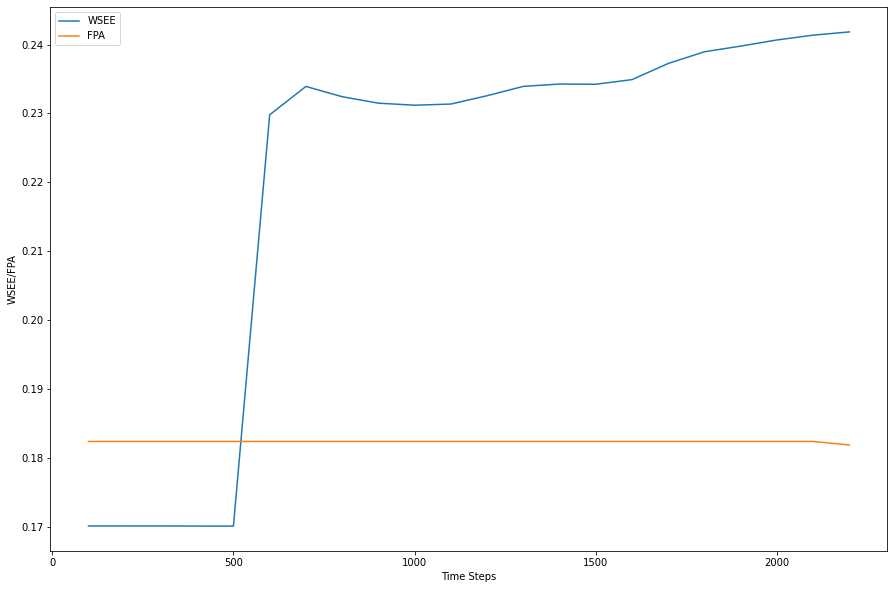

In [15]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_wsee, label='WSEE')
plt.plot(episode, eval_fpa, label='FPA')
plt.xlabel('Time Steps')
plt.ylabel('WSEE/FPA')
plt.legend()
plt.savefig(dest/r'training.jpg', dpi=300)

Text(0, 0.5, 'Reward')

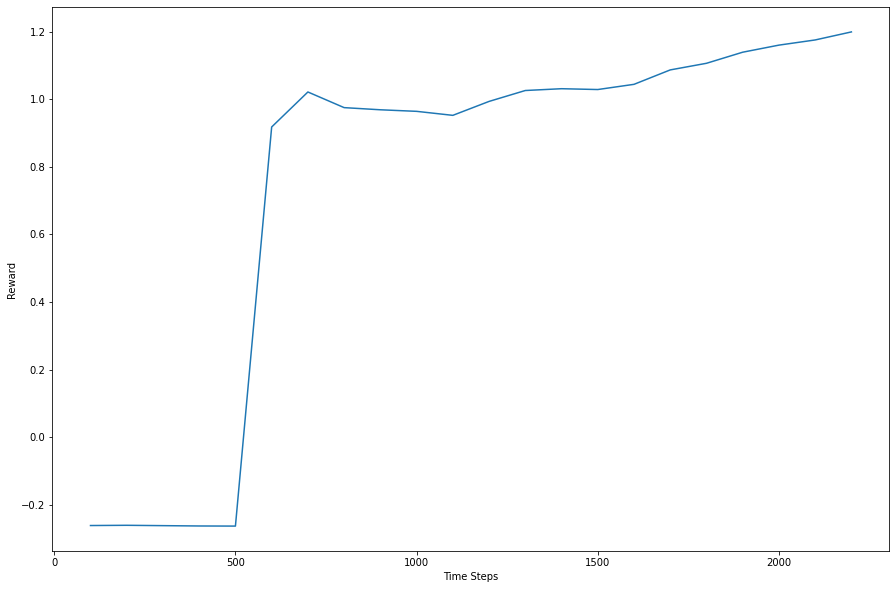

In [16]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_reward)
plt.xlabel('Time Steps')
plt.ylabel('Reward')
